In [58]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import ndimage
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

import matplotlib.pyplot as plt

import SimpleITK as sitk
import itk

from pyitk.image3d import ImageITK, ImageSITK, ImageNumpy, itkindex

test_ct = 'data/panoramix.gipl'
test_seg = 'data/panoramix_seg.gipl'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outline

1. SimpleITK vs ITK

2. Examples of operations, speed comparison with Scipy

3. Resources

## SimpleITK or ITK


### ITK

ITK is an open-source, cross-platform system that provides developers with an **extensive suite of software tools for image analysis**.  Developed through extreme programming methodologies, ITK employs leading-edge algorithms for registering and segmenting multidimensional data. 


### SimpleITK

SimpleITK is a **simplified**, open source, **interface** to the National Library of Medicine’s Insight Segmentation and Registration Toolkit (ITK), a C++ open source image analysis toolkit which is widely used in academia and industry. SimpleITK is available for eight programming languages including C++, **Python**, R, Java, C#, Lua, Ruby, and TCL. Binary distributions of SimpleITK are currently available for all three major operating systems (Linux, OS X, and Windows).


### scipy.ndimage

https://docs.scipy.org/doc/scipy/reference/ndimage.html

## Reading images in


In [30]:
reader = sitk.ImageFileReader()
reader.GetRegisteredImageIOs()

('BMPImageIO',
 'BioRadImageIO',
 'Bruker2dseqImageIO',
 'GDCMImageIO',
 'GE4ImageIO',
 'GE5ImageIO',
 'GiplImageIO',
 'HDF5ImageIO',
 'JPEGImageIO',
 'LSMImageIO',
 'MINCImageIO',
 'MRCImageIO',
 'MetaImageIO',
 'NiftiImageIO',
 'NrrdImageIO',
 'PNGImageIO',
 'StimulateImageIO',
 'TIFFImageIO',
 'VTKImageIO')

In [4]:
%%timeit
itk.imread(test_ct)

231 ms ± 9.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
sitk.ReadImage(test_ct)

138 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%%timeit
sitk.GetArrayFromImage(sitk.ReadImage(test_ct))

180 ms ± 8.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
im_itk = ImageITK(test_ct)
im_sitk = ImageSITK(test_ct)
im_np = ImageNumpy(test_ct)

## Image Properties
taken from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html

![Naming conventions in ITK](data/coordinates.png "Naming conventions in ITK")

In [6]:
for attr in ('Size', 'Depth', 'Width', 'Height', 'NumberOfComponentsPerPixel', 'Origin', 'Spacing', 'Direction'):
    print(f'{attr}:', getattr(im_sitk, f'Get{attr}')())
    if attr == 'NumberOfComponentsPerPixel':
        print('--------------------------------')

print('\nDirection matrix:')        
for i in range(3):
    print(im_sitk.GetDirection()[i*3:(i+1)*3])

Size: (512, 512, 288)
Depth: 288
Width: 512
Height: 512
NumberOfComponentsPerPixel: 1
--------------------------------
Origin: (0.0, 0.0, 0.0)
Spacing: (0.7421875, 0.7421875, 1.5)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

Direction matrix:
(1.0, 0.0, 0.0)
(0.0, 1.0, 0.0)
(0.0, 0.0, 1.0)


In [7]:
print(im_itk.GetOrigin())
print(im_itk.GetDirection())

itkPointD3 ([0, 0, 0])
<itkMatrixPython.itkMatrixD33; proxy of <Swig Object of type 'itkMatrixD33 *' at 0x7f706e0b47e0> >


In [30]:
print(im_itk.GetDirection()(0, 0))

1.0


## Applying filters

In [8]:
filtered_numpy = ndimage.median_filter(im_np.img, size=3)

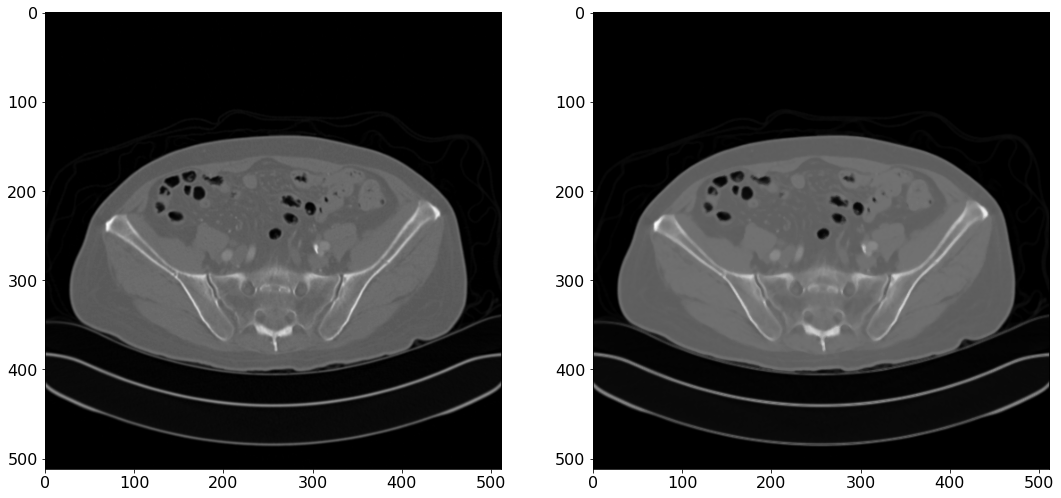

In [9]:
fig2, ax2 = plt.subplots(1, 2, figsize=(18, 14))
slice_orig = 100
ax2[0].imshow(im_np.img[slice_orig], cmap='gray')
ax2[1].imshow(filtered_numpy[slice_orig], cmap='gray')

In [8]:
%%timeit
ndimage.median_filter(im_np.img, size=3)

28 s ± 475 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
help(ndimage.median_filter)

Help on function median_filter in module scipy.ndimage.filters:

median_filter(input, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
    Calculate a multidimensional median filter.
    
    Parameters
    ----------
    input : array_like
        The input array.
    size : scalar or tuple, optional
        See footprint, below. Ignored if footprint is given.
    footprint : array, optional
        Either `size` or `footprint` must be defined.  `size` gives
        the shape that is taken from the input array, at every element
        position, to define the input to the filter function.
        `footprint` is a boolean array that specifies (implicitly) a
        shape, but also which of the elements within this shape will get
        passed to the filter function.  Thus ``size=(n,m)`` is equivalent
        to ``footprint=np.ones((n,m))``.  We adjust `size` to the number
        of dimensions of the input array, so that, if the input array is
        shape 

## ITK's C++ interface

In [10]:
def median_itk_old(input_image, radius):
    ImageType = type(input_image)

    median_filter = itk.MedianImageFilter[ImageType, ImageType].New()
    median_filter.SetInput(input_image)
    median_filter.SetRadius(radius)
    median_filter.Update()
    return median_filter.GetOutput()

## ITK's Pythonic interface

In [11]:
med_itk = itk.median_image_filter(im_itk.img, radius=1)

## ITK's NumPy interface (ITK >=5.1)

In [12]:
print(type(im_np.img))
med_itk_numpy = itk.median_image_filter(im_np.img, radius=1)

<class 'numpy.ndarray'>


In [57]:
%%timeit
median_itk_old(im_itk.img, radius=1)

6.31 s ± 64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%%timeit
itk.median_image_filter(im_itk.img, radius=1)

6.35 s ± 78.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%%timeit
itk.median_image_filter(im_np.img, radius=1)

6.51 s ± 97.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## SimpleITK

In [13]:
med_sitk = sitk.Median(im_sitk.img, (1, 1, 1))

In [14]:
%%timeit
med_sitk = sitk.Median(im_sitk.img, (1, 1, 1))

4.5 s ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
np.testing.assert_array_equal(filtered_numpy, np.asarray(med_itk))
np.testing.assert_array_equal(filtered_numpy, sitk.GetArrayViewFromImage(med_sitk))

## Converting between Simple(ITK) and NumPy

In [16]:
test_array = np.zeros(shape=(10, 10, 10))
test_array[4, 5, 6] = 42
test_array_itk = itk.image_from_array(test_array)
print('NumPy value:', test_array[4, 5, 6])
print('ITK value:', test_array_itk.GetPixel(itkindex(6, 5, 4)))

NumPy value: 42.0
ITK value: 42.0


In [17]:
test_array_sitk = sitk.GetImageFromArray(test_array)
print('SimpleITK value:', test_array_sitk[6, 5, 4])

SimpleITK value: 42.0


## NumPy view from Image

In [18]:
test_array_sitk = sitk.GetImageFromArray(test_array)
array_view = sitk.GetArrayViewFromImage(test_array_sitk)
print('NumPy view value:', array_view[4, 5, 6])
test_array_sitk[6, 5, 4] = 13.0
print('NumPy view value:', array_view[4, 5, 6])
print('NumPy view shape:', array_view.shape)

NumPy view value: 42.0
NumPy view value: 13.0
NumPy view shape: (10, 10, 10)


## Resampling

In [19]:
scaling = im_sitk.GetSpacing()
print(scaling)

(0.7421875, 0.7421875, 1.5)


In [20]:
zoomed = ndimage.zoom(im_np.img, scaling[::-1])

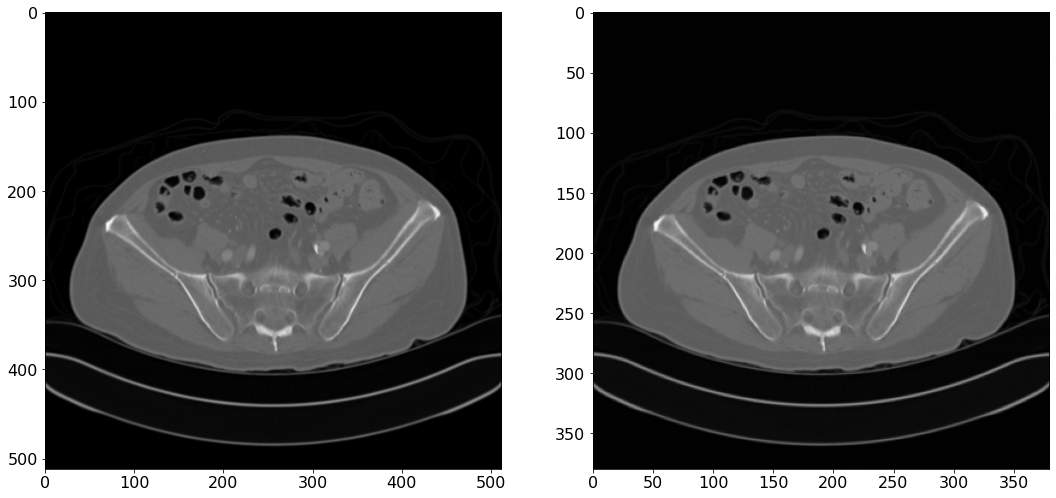

In [21]:
fig1, ax1 = plt.subplots(1, 2, figsize=(18, 14))
slice_orig = 100
slice_resampled = int(100*scaling[2])
ax1[0].imshow(im_np.img[slice_orig], cmap='gray')
ax1[1].imshow(zoomed[slice_resampled], cmap='gray')

In [22]:
%%timeit
ndimage.zoom(im_np.img, scaling[::-1])

24.3 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
help(ndimage.zoom)

Help on function zoom in module scipy.ndimage.interpolation:

zoom(input, zoom, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    Zoom an array.
    
    The array is zoomed using spline interpolation of the requested order.
    
    Parameters
    ----------
    input : array_like
        The input array.
    zoom : float or sequence
        The zoom factor along the axes. If a float, `zoom` is the same for each
        axis. If a sequence, `zoom` should contain one value for each axis.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    order : int, optional
        The order of the spline interpolation, default is 3.
        The order has to be in the range 0-5.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
        The `mode` parameter determines how the input array is extended
       

In [24]:
# One-line resampling in ITK (different interpolator)
resampled_img = itk.resample_image_filter(im_itk.img, size=zoomed.shape[::-1], output_spacing=(1., 1., 1.))

## SimpleITK limitation -- no kwargs

In [27]:
reference_image = sitk.Image(zoomed.shape[::-1], im_sitk.GetPixelIDValue())
reference_image.SetSpacing((1., 1., 1.))
zoomed_sitk = sitk.Resample(im_sitk.img, reference_image, interpolator=sitk.sitkBSpline)

TypeError: Resample() got an unexpected keyword argument 'interpolator'

In [28]:
zoomed_sitk = sitk.Resample(im_sitk.img, reference_image, sitk.sitkBSpline)

NotImplementedError: Wrong number or type of arguments for overloaded function 'Resample'.
  Possible C/C++ prototypes are:
    itk::simple::Resample(itk::simple::Image const &,itk::simple::Transform,itk::simple::InterpolatorEnum,double,itk::simple::PixelIDValueEnum)
    itk::simple::Resample(itk::simple::Image const &,itk::simple::Image const &,itk::simple::Transform,itk::simple::InterpolatorEnum,double,itk::simple::PixelIDValueEnum)
    itk::simple::Resample(itk::simple::Image const &,std::vector< uint32_t,std::allocator< uint32_t > >,itk::simple::Transform,itk::simple::InterpolatorEnum,std::vector< double,std::allocator< double > >,std::vector< double,std::allocator< double > >,std::vector< double,std::allocator< double > >,double,itk::simple::PixelIDValueEnum)


In [29]:
%%timeit
reference_image = sitk.Image(zoomed.shape[::-1], im_sitk.GetPixelIDValue())
reference_image.SetSpacing((1., 1., 1.))
translation = sitk.TranslationTransform(3)
sitk.Resample(im_sitk.img, reference_image, translation, sitk.sitkBSpline)

13.4 s ± 1.62 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Morphological operations

* erosion
* dilation
* opening
* closing

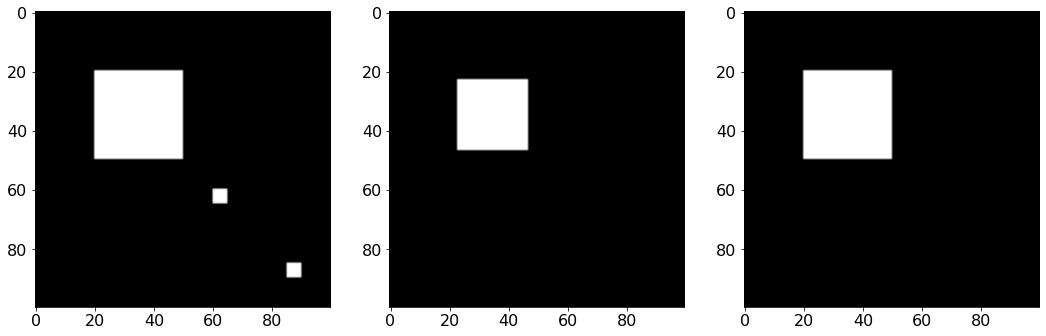

In [32]:
rect_array = np.zeros((100, 100), dtype=np.uint8)
rect_array[20:50, 20:50] = 1
rect_array[85:90, 85:90] = 1
rect_array[60:65, 60:65] = 1
fig3, ax3 = plt.subplots(1, 3, figsize=(18, 14))
ax3[0].imshow(rect_array, cmap='gray')
structure = ndimage.generate_binary_structure(2, 2)
eroded = ndimage.binary_erosion(rect_array, structure=structure, iterations=3)
ax3[1].imshow(eroded, cmap='gray')
dilated = ndimage.binary_dilation(eroded, structure=structure, iterations=3)
ax3[2].imshow(dilated, cmap='gray')

In [33]:
seg_fname = 'data/panoramix_seg.gipl'
segmentation_sitk = ImageSITK(seg_fname)
segmentation_np = ImageNumpy(seg_fname)

In [34]:
seg = segmentation_sitk.img
dilated = sitk.BinaryDilate(seg)
hollow = sitk.Subtract(dilated, seg)

In [36]:
sitk.WriteImage(hollow, '/tmp/segmentation_hollow.gipl')

## ITK is not always faster

In [37]:
%%timeit
sitk.BinaryDilate(seg, sitk.sitkCross)

2.28 s ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
ndimage.binary_dilation(segmentation_np.img)


868 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Connected components

In [39]:
segmentation_cut = sitk.ReadImage('data/panoramix_seg_cut.gipl')
labels = sitk.Cast(sitk.ConnectedComponent(segmentation_cut), 3)
sitk.WriteImage(labels, '/tmp/cc.gipl')

## Documentation

https://simpleitk.readthedocs.io/en/master/Documentation/docs/source/filters.html

https://itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html

## Resources

https://numpy.org/neps/nep-0030-duck-array-protocol.html

https://itk.org/ITKExamples/src/index.html
https://itk.org/ITKExamples/src/Filtering/Thresholding/ThresholdAnImage/Documentation.html

https://simpleitk.readthedocs.io/en/master/index.html

https://discourse.itk.org/

https://github.com/KitwareMedicalPublications/2018-05-30-KRSCourseInBiomedicalImageAnalysisAndVisualization

http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

In [53]:
def composite_filter(input_image, radius):
    ImageType = type(input_image)

    median_filter = itk.MedianImageFilter[ImageType, ImageType].New()
    median_filter.SetInput(input_image)
    median_filter.SetRadius(radius)
    #median_filter.Update()
    
    windowing_filter = itk.IntensityWindowingImageFilter[ImageType, ImageType].New()
    windowing_filter.SetInput(median_filter.GetOutput())
    windowing_filter.SetWindowMinimum(1000)
    windowing_filter.SetWindowMaximum(2000)
    windowing_filter.SetOutputMinimum(0)
    windowing_filter.SetOutputMaximum(1000)
    windowing_filter.Update()
    
    return windowing_filter.GetOutput()

In [54]:
windowed = composite_filter(im_itk.img, 1)

In [55]:
itk.imwrite(windowed, '/tmp/windowed.gipl')

In [ ]:
r8f